# Time series forecasting : 

---

### Loading data

In [268]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

sns.set_theme()
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [269]:
df = pd.read_csv("data.csv", parse_dates=['date'])

target = 'Close_BTC'

target_features = [col for col in df.columns if col.startswith('Close_') and not df[col].isna().any()]

df['dayofweek'] = df['date'].dt.dayofweek
df = pd.get_dummies(df, columns=['dayofweek'])

target, target_features

('Close_BTC', ['Close_BTC', 'Close_ETH'])

In [270]:
print("number of rows", df.shape[0])

min_date = df[df[target].notnull()]['date'].min()
max_date = df[df[target].notnull()]['date'].max()
end_training = datetime.datetime(2022, 8, 31)
start_validation = end_training + datetime.timedelta(days=1)
print(f"Data ranging from {min_date.strftime('%d-%m-%Y')} to {max_date.strftime('%d-%m-%Y')}")
print("Training dataset : ", min_date.strftime('%d-%m-%Y'), end_training.strftime('%d-%m-%Y'))
print("Validation dataset : ", start_validation.strftime('%d-%m-%Y'), max_date.strftime('%d-%m-%Y'))

temp_df = df[(df['date'] >= min_date) & (df['date'] <= end_training)]
n = len(temp_df)

train_df = temp_df.iloc[:int(n*0.75)].copy()
test_df = temp_df.iloc[int(n*0.75):].copy()

val_df = df[(df['date'] >= start_validation) & (df['date'] <= max_date)].copy()
print("number of rows in training dataset: ", train_df.shape[0])
print("number of rows in test dataset: ", test_df.shape[0])
print("number of rows in validation dataset: ", val_df.shape[0])

train_df.drop(columns=['date'], inplace=True)
val_df.drop(columns=['date'], inplace=True)
test_df.drop(columns=['date'], inplace=True)

date_time = df['date']

number of rows 1462
Data ranging from 17-08-2017 to 24-03-2023
Training dataset :  17-08-2017 31-08-2022
Validation dataset :  01-09-2022 24-03-2023
number of rows in training dataset:  986
number of rows in test dataset:  329
number of rows in validation dataset:  147


### Preprocessing data

In [271]:
# Extract targets before PCA
train_df_target = train_df[target_features]
val_df_target = val_df[target_features]
test_df_target = test_df[target_features]
# Drop targets from features
train_df_no_target = train_df.drop(target_features, axis=1)
val_df_no_target = val_df.drop(target_features, axis=1)
test_df_no_target = test_df.drop(target_features, axis=1)
# Use KNN to impute missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_df_preprocess = imputer.fit_transform(train_df_no_target)
val_df_preprocess = imputer.transform(val_df_no_target)
test_df_preprocess = imputer.transform(test_df_no_target)
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df_preprocess = scaler.fit_transform(train_df_preprocess)
val_df_preprocess = scaler.transform(val_df_preprocess)
test_df_preprocess = scaler.transform(test_df_preprocess)
# Scale targets
scaler_target = StandardScaler()
train_df_target = pd.DataFrame(scaler_target.fit_transform(train_df_target), columns=target_features)
val_df_target = pd.DataFrame(scaler_target.transform(val_df_target), columns=target_features)
test_df_target = pd.DataFrame(scaler_target.transform(test_df_target), columns=target_features)
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.85)
pca.fit(train_df_preprocess)
train_df_preprocess = pca.transform(train_df_preprocess)
val_df_preprocess = pca.transform(val_df_preprocess)
test_df_preprocess = pca.transform(test_df_preprocess)
# Re-add targets
train_df_preprocess = pd.DataFrame(train_df_preprocess)
train_df_preprocess = pd.concat([train_df_preprocess, train_df_target[['Close_BTC', 'Close_ETH']]], axis=1)
val_df_preprocess = pd.DataFrame(val_df_preprocess)
# Make val_df_preprocess use index from val_df_target
val_df_preprocess.index = val_df_target.index
val_df_preprocess = pd.concat([val_df_preprocess, val_df_target[['Close_BTC', 'Close_ETH']]], axis=1)
test_df_preprocess = pd.DataFrame(test_df_preprocess)
test_df_preprocess.index = test_df_target.index
test_df_preprocess = pd.concat([test_df_preprocess, test_df_target[['Close_BTC', 'Close_ETH']]], axis=1)

# Print shape
num_features = train_df_preprocess.shape[1]
column_indices = {name: i for i, name in enumerate(train_df_preprocess.columns)}

train_df = train_df_preprocess
val_df = val_df_preprocess
test_df = test_df_preprocess

train_df.shape, val_df.shape, test_df.shape

((986, 75), (147, 75), (329, 75))

### Class definition

In [272]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [273]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [274]:
def plot(self, model=None, plot_col=target, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [275]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [276]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Defining windows

In [277]:
WIDTH = 2

full_window = WindowGenerator(input_width=len(train_df)-1, label_width=len(train_df)-1, shift=1, label_columns=[target])
wide_window = WindowGenerator(input_width=WIDTH, label_width=WIDTH, shift=1, label_columns=[target])
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[target])

### Defining model fitting and training

In [278]:
MAX_EPOCHS = 100
LEARNING_RATE = 1e-4*2
PATIENCE = 5

def compile_and_fit(model, window, patience=PATIENCE):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
  
  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.keras.optimizers.Adam(),
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.MeanAbsoluteError()])

  print("Training data shape:", window.train)
  print("Validation data shape:", window.val)

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      verbose=1)
  return history

### Naive model

In [279]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [280]:
baseline = Baseline(label_index=column_indices[target])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 19ms/step - loss: 0.0033 - mean_absolute_error: 0.0365


In [281]:
# wide_window.plot(baseline)

### Linear model

In [282]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 75)
Output shape: (32, 1, 1)


In [283]:
history = compile_and_fit(linear, wide_window)

IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 5ms/step - loss: 2.4857 - mean_absolute_error: 1.2975


In [284]:
# wide_window.plot(linear)
# full_window.plot(linear)

### Dense neural net model

In [285]:
from tensorflow.keras import regularizers

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 3s 64ms/step - loss: 5.1879 - mean_absolute_error: 1.4433 - val_loss: 15.0895 - val_mean_absolute_error: 3.4719
Epoch 2/100
31/31 [==============================] - 1s 40ms/step - loss: 4.2128 - mean_absolute_error: 1.2842 - val_loss: 13.9178 - val_mean_absolute_error: 3.3397
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 3.8423 - mean_absolute_error: 1.1531 - val_loss: 12.6869 - val_mean_absolute_error: 3.1886
Epoch 4/100
31/31 [==============================] - 1s 32ms/step - loss: 3.4244 - mean_absolute_error: 1.0908 - val_loss: 12.4189 - val_mean_absolute_error: 3

### Multi-step dense model

In [286]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [287]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', multi_step_dense(wide_window.example[0]).shape)

Input shape: (32, 2, 75)
Output shape: (32, 1, 1)


In [288]:
history = compile_and_fit(multi_step_dense, wide_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(wide_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 21ms/step - loss: 2.0854 - mean_absolute_error: 0.9654


### LSTM model

In [289]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [290]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 2, 75)
Output shape: (32, 2, 1)


In [291]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 3s 54ms/step - loss: 0.7939 - mean_absolute_error: 0.5799 - val_loss: 0.3623 - val_mean_absolute_error: 0.5208
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.6552 - mean_absolute_error: 0.5229 - val_loss: 0.4020 - val_mean_absolute_error: 0.5561
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.5368 - mean_absolute_error: 0.4714 - val_loss: 0.4373 - val_mean_absolute_error: 0.5863
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.4375 - mean_absolute_error: 0.4246 - val_loss: 0.4701 - val_mean_absolute_error: 0.613

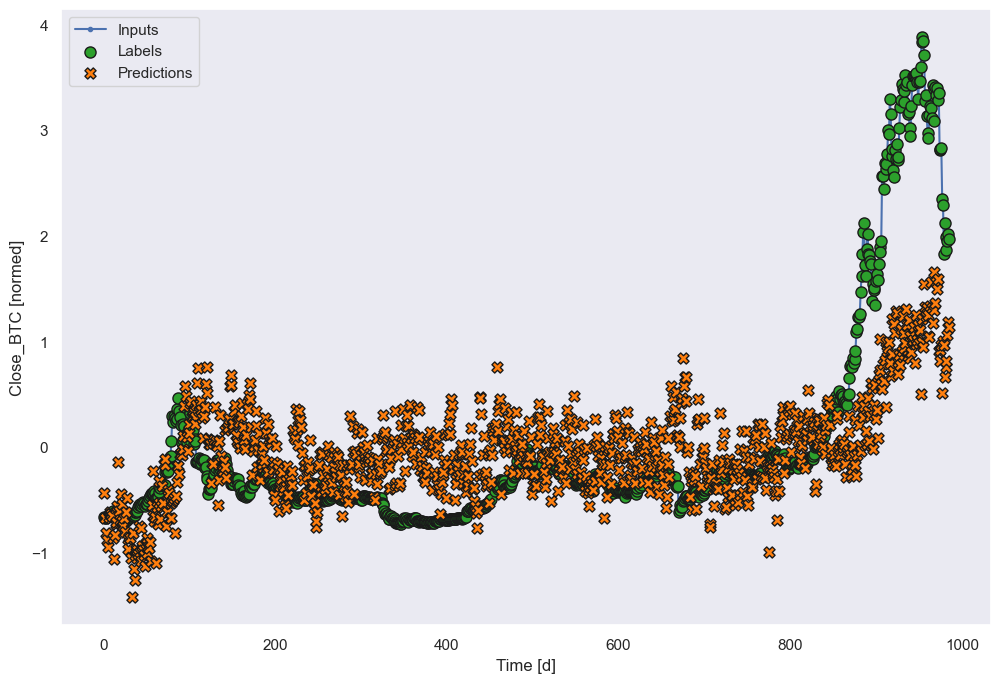

In [292]:
full_window.plot(lstm_model)

### SDAE LSTM model

In [293]:
# Define the SDAE model
sdae_lstm = tf.keras.models.Sequential([
    # SDAE
    # Encoder
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    # Decoder
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # LSTM
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# Compile and fit the model
history = compile_and_fit(sdae_lstm, wide_window)

# Evaluate the model
val_performance['SDAE_LSTM'] = sdae_lstm.evaluate(wide_window.val)
performance['SDAE_LSTM'] = sdae_lstm.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 75), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 4s 82ms/step - loss: 0.9374 - mean_absolute_error: 0.5889 - val_loss: 0.5844 - val_mean_absolute_error: 0.7183
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5113 - mean_absolute_error: 0.3858 - val_loss: 2.4048 - val_mean_absolute_error: 1.4857
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 0.1434 - mean_absolute_error: 0.2374 - val_loss: 1.3167 - val_mean_absolute_error: 1.0996
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 0.0777 - mean_absolute_error: 0.1786 - val_loss: 1.4759 - val_mean_absolute_error: 1.178

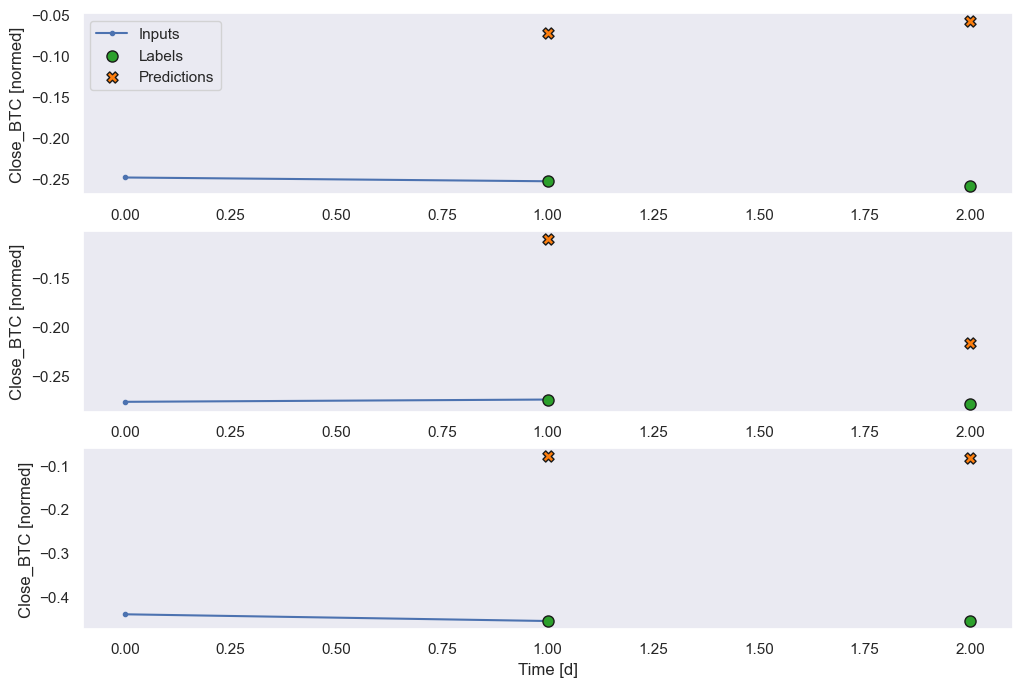

In [294]:
wide_window.plot(sdae_lstm)

### Results

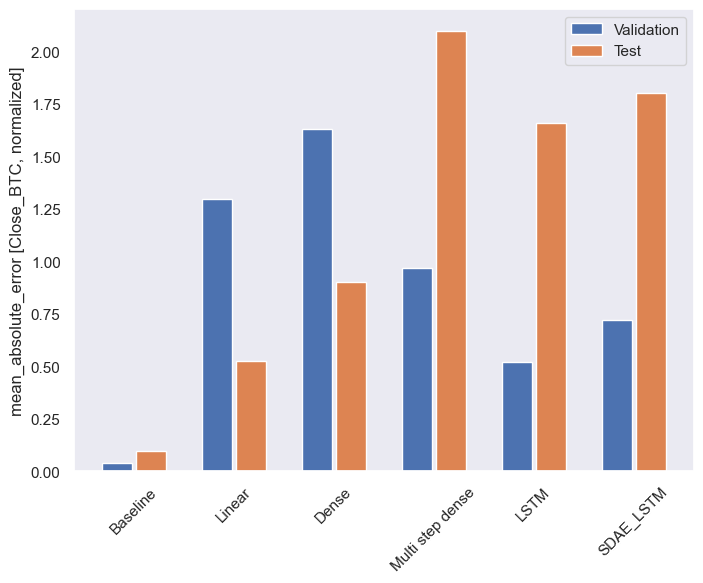

In [295]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close_BTC, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [296]:
# Columns : Test MSE, Validation MSE, Test MAE, Validation MAE
result = pd.DataFrame(columns=['Test MSE', 'Validation MSE', 'Test MAE', 'Validation MAE'])
for model in performance.keys():
  result.loc[model] = [performance[model][0], val_performance[model][0], performance[model][1], val_performance[model][1]]

display((f"window width: {WIDTH}", f"patience : {PATIENCE}",f"learning rate : {LEARNING_RATE}", f"max epoch : {MAX_EPOCHS}"))
result

('window width: 2',
 'patience : 5',
 'learning rate : 0.0002',
 'max epoch : 100')

,Test MSE,Validation MSE,Test MAE,Validation MAE
Baseline,0.017527,0.003275,0.095783,0.036498
Linear,0.453679,2.485665,0.525755,1.297458
Dense,1.688186,3.508505,0.898893,1.629781
Multi step dense,5.733159,2.085368,2.095390,0.965438
LSTM,3.436749,0.362271,1.656808,0.520766
SDAE_LSTM,3.868540,0.584419,1.802348,0.718344
